In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install -q mlflow
!pip install -q python-dotenv

In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.express as px

import os

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2024.pkl'))

In [8]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,2,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,3,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,4,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,5,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [9]:
cols_tot_rank = [col for col in df.columns if '_tot' in col or '_rank' in col]
cols_to_drop = ['Rk', 'G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos', 'Age', 'G', 'GS', 'FGA_pg', 'FG%', '3P_pg', '3PA_pg', '3P%', '2PA_pg', '2P%', 'eFG%', 'FT%', 'ORB_pg', 'DRB_pg', 'PF_pg', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'OBPM', 'DBPM']
cols_to_drop += cols_tot_rank
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [10]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    # ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('AdjustColumns', prep.AdjustCols(cols_to_adjust = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [11]:
df = pipe_clean.fit_transform(df)

In [12]:
df.head()

,,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1982,35.2,9.9,9.9,4.1,5.8,8.7,3.0,0.8,2.7,3.0,...,0.256,6.9,3.9,10.7,0.192,5.0,4.7,0.695,0.927,0.045
2,1982,30.3,6.4,6.4,2.3,2.9,7.4,4.5,1.4,1.0,2.5,...,0.228,2.5,4.7,7.2,0.144,3.6,3.4,0.561,0.963,0.000
3,1982,28.8,7.5,7.0,3.3,4.8,4.9,3.2,0.7,0.4,2.6,...,0.298,1.0,0.8,1.9,0.061,0.7,1.0,0.341,0.622,0.000
4,1982,10.6,1.5,1.4,1.1,1.2,1.1,1.6,0.7,0.1,1.0,...,0.215,-0.3,0.8,0.5,0.042,-2.7,-0.1,0.768,0.646,0.000
5,1982,31.9,4.5,4.4,3.5,4.6,1.7,8.0,0.8,0.0,2.6,...,0.179,3.4,1.8,5.2,0.115,0.1,1.1,0.768,0.829,0.000


In [13]:
len(df[df.index.get_level_values(1) > 2017]) / len(df)

0.20496597192683963

In [14]:
val_df = df[df.index.get_level_values(1) > 2017]
dev_df = df[df.index.get_level_values(1) <= 2017]

In [15]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [16]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [17]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [18]:
pd.concat([X_train, X_val], ignore_index = True)

,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,PER,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G
0,35.2,9.9,9.9,4.1,5.8,8.7,3.0,0.8,2.7,3.0,...,23.4,0.256,6.9,3.9,10.7,0.192,5.0,4.7,0.695,0.927
1,30.3,6.4,6.4,2.3,2.9,7.4,4.5,1.4,1.0,2.5,...,18.6,0.228,2.5,4.7,7.2,0.144,3.6,3.4,0.561,0.963
2,28.8,7.5,7.0,3.3,4.8,4.9,3.2,0.7,0.4,2.6,...,17.3,0.298,1.0,0.8,1.9,0.061,0.7,1.0,0.341,0.622
3,10.6,1.5,1.4,1.1,1.2,1.1,1.6,0.7,0.1,1.0,...,10.1,0.215,-0.3,0.8,0.5,0.042,-2.7,-0.1,0.768,0.646
4,31.9,4.5,4.4,3.5,4.6,1.7,8.0,0.8,0.0,2.6,...,14.3,0.179,3.4,1.8,5.2,0.115,0.1,1.1,0.768,0.829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23954,13.3,2.0,1.9,0.2,0.5,3.1,1.7,0.7,0.2,0.5,...,5.0,0.050,0.9,0.4,1.3,0.000,0.3,0.2,0.394,0.402
23955,36.0,8.0,4.8,6.4,7.5,2.8,10.8,1.3,0.2,4.4,...,20.3,0.305,4.0,0.6,4.6,0.114,2.6,2.2,0.439,0.659
23956,11.4,2.1,2.0,0.4,0.6,4.3,0.6,0.2,0.4,0.8,...,15.0,0.179,0.3,0.4,0.7,0.062,-3.0,-0.1,0.378,0.585
23957,7.4,0.6,0.6,0.5,0.9,2.6,0.9,0.2,0.1,0.4,...,12.8,0.129,0.4,0.4,0.8,0.124,-2.6,0.0,0.598,0.524


In [19]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [20]:
pipe_scale = Pipeline(steps = [
    ('Scaler', scaler),
    ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
])

In [21]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [22]:
mlflow.set_experiment('Linear Regression Simple')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/2', creation_time=1697481748640, experiment_id='2', last_update_time=1697481748640, lifecycle_stage='active', name='Linear Regression Simple', tags={}>

In [24]:
with mlflow.start_run():
    model = LinearRegression()

    cv_scores = cross_validate(model, X_train, y_train, scoring = ('neg_root_mean_squared_error', 'r2'), cv = 10)

    model.fit(X_train, y_train)

    predicted_targets = mod.predict_model(model, datasets)

    params = model.get_params()

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_linear_coef(model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list))

2024/09/22 17:00:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/22 17:00:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-worm-372 at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/2/runs/85f802fcde9e4283afd6b55efa1431ad.
2024/09/22 17:00:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://nba-mvp-prediction.xyz/mlflow/#/experiments/2.


In [25]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.114476,0.099479,0.056571
R2,0.471755,0.091084,-0.057638


In [27]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

In [28]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.340586
249,2018,LeBron James,0.731,0.417758
122,2018,Anthony Davis,0.441,0.228497
298,2018,Damian Lillard,0.205,0.238211
508,2018,Russell Westbrook,0.075,0.317258
16,2018,Giannis Antetokounmpo,0.074,0.242175
143,2018,Kevin Durant,0.065,0.226610
130,2018,DeMar DeRozan,0.032,0.105152
7,2018,LaMarcus Aldridge,0.006,0.143237


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.381303
207,2019,James Harden,0.768,0.429479
184,2019,Paul George,0.352,0.238658
270,2019,Nikola Jokić,0.210,0.335374
124,2019,Stephen Curry,0.173,0.168171
305,2019,Damian Lillard,0.068,0.244721
155,2019,Joel Embiid,0.049,0.176903
150,2019,Kevin Durant,0.025,0.235044
301,2019,Kawhi Leonard,0.013,0.122598


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.358627
251,2020,LeBron James,0.746,0.298489
199,2020,James Harden,0.363,0.294054
134,2020,Luka Dončić,0.198,0.265175
294,2020,Kawhi Leonard,0.166,0.161471
123,2020,Anthony Davis,0.081,0.181068
396,2020,Chris Paul,0.026,0.074761
297,2020,Damian Lillard,0.023,0.195400
262,2020,Nikola Jokić,0.018,0.249053


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.437838
146,2021,Joel Embiid,0.580,0.120856
116,2021,Stephen Curry,0.449,0.212132
12,2021,Giannis Antetokounmpo,0.345,0.263552
396,2021,Chris Paul,0.138,0.105253
130,2021,Luka Dončić,0.042,0.253707
297,2021,Damian Lillard,0.038,0.169119
421,2021,Julius Randle,0.020,0.173091
439,2021,Derrick Rose,0.010,0.025494


,,Player,Share,PredShare
Rk,Season,,,
290,2022,Nikola Jokić,0.875,0.510923
162,2022,Joel Embiid,0.706,0.276206
12,2022,Giannis Antetokounmpo,0.595,0.356359
59,2022,Devin Booker,0.216,0.122322
141,2022,Luka Dončić,0.146,0.287277
526,2022,Jayson Tatum,0.043,0.209500
390,2022,Ja Morant,0.010,0.160163
126,2022,Stephen Curry,0.004,0.152610
438,2022,Chris Paul,0.002,0.095023


,,Player,Share,PredShare
Rk,Season,,,
143,2023,Joel Embiid,0.915,0.280568
249,2023,Nikola Jokić,0.674,0.436994
11,2023,Giannis Antetokounmpo,0.606,0.299922
465,2023,Jayson Tatum,0.280,0.201701
164,2023,Shai Gilgeous-Alexander,0.046,0.186984
338,2023,Donovan Mitchell,0.030,0.165647
428,2023,Domantas Sabonis,0.027,0.287893
125,2023,Luka Dončić,0.010,0.287584
108,2023,Stephen Curry,0.005,0.171112


,,Player,Share,PredShare
Rk,Season,,,
263,2024,Nikola JokiÄ,0.935,0.556941
172,2024,Shai Gilgeous-Alexander,0.646,0.281947
128,2024,Luka DonÄiÄ,0.572,0.384501
11,2024,Giannis Antetokounmpo,0.194,0.381274
76,2024,Jalen Brunson,0.143,0.245393
489,2024,Jayson Tatum,0.087,0.196110
140,2024,Anthony Edwards,0.018,0.138136
444,2024,Domantas Sabonis,0.003,0.346995
137,2024,Kevin Durant,0.001,0.185539


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2018,Álex Abrines,0.0,0.018695
3,2018,Steven Adams,0.0,0.026894
4,2018,Bam Adebayo,0.0,0.008158
5,2018,Arron Afflalo,0.0,0.017832
6,2018,Cole Aldrich,0.0,0.039026
...,...,...,...,...
565,2024,Isaiah Wong,0.0,0.043144
568,2024,Thaddeus Young,0.0,0.040214
569,2024,Trae Young,0.0,0.035721


In [29]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
112,2018,DeMarcus Cousins,0.0,0.118747
140,2018,Andre Drummond,0.0,0.130026
228,2018,Al Horford,0.0,0.135152
240,2018,Kyrie Irving,0.0,0.145170
264,2018,Nikola Jokić,0.0,0.241976
...,...,...,...,...
293,2024,Kawhi Leonard,0.0,0.119064
455,2024,Alperen Sengun,0.0,0.145933
462,2024,Pascal Siakam,0.0,0.102952


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Linear coefficient'>

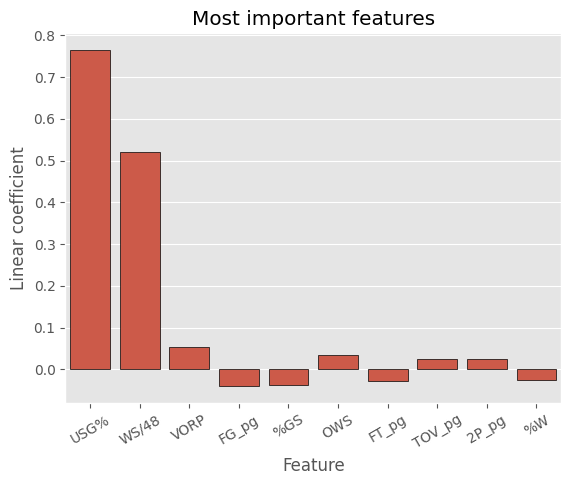

In [30]:
mod.display_linear_coef(model)

In [32]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

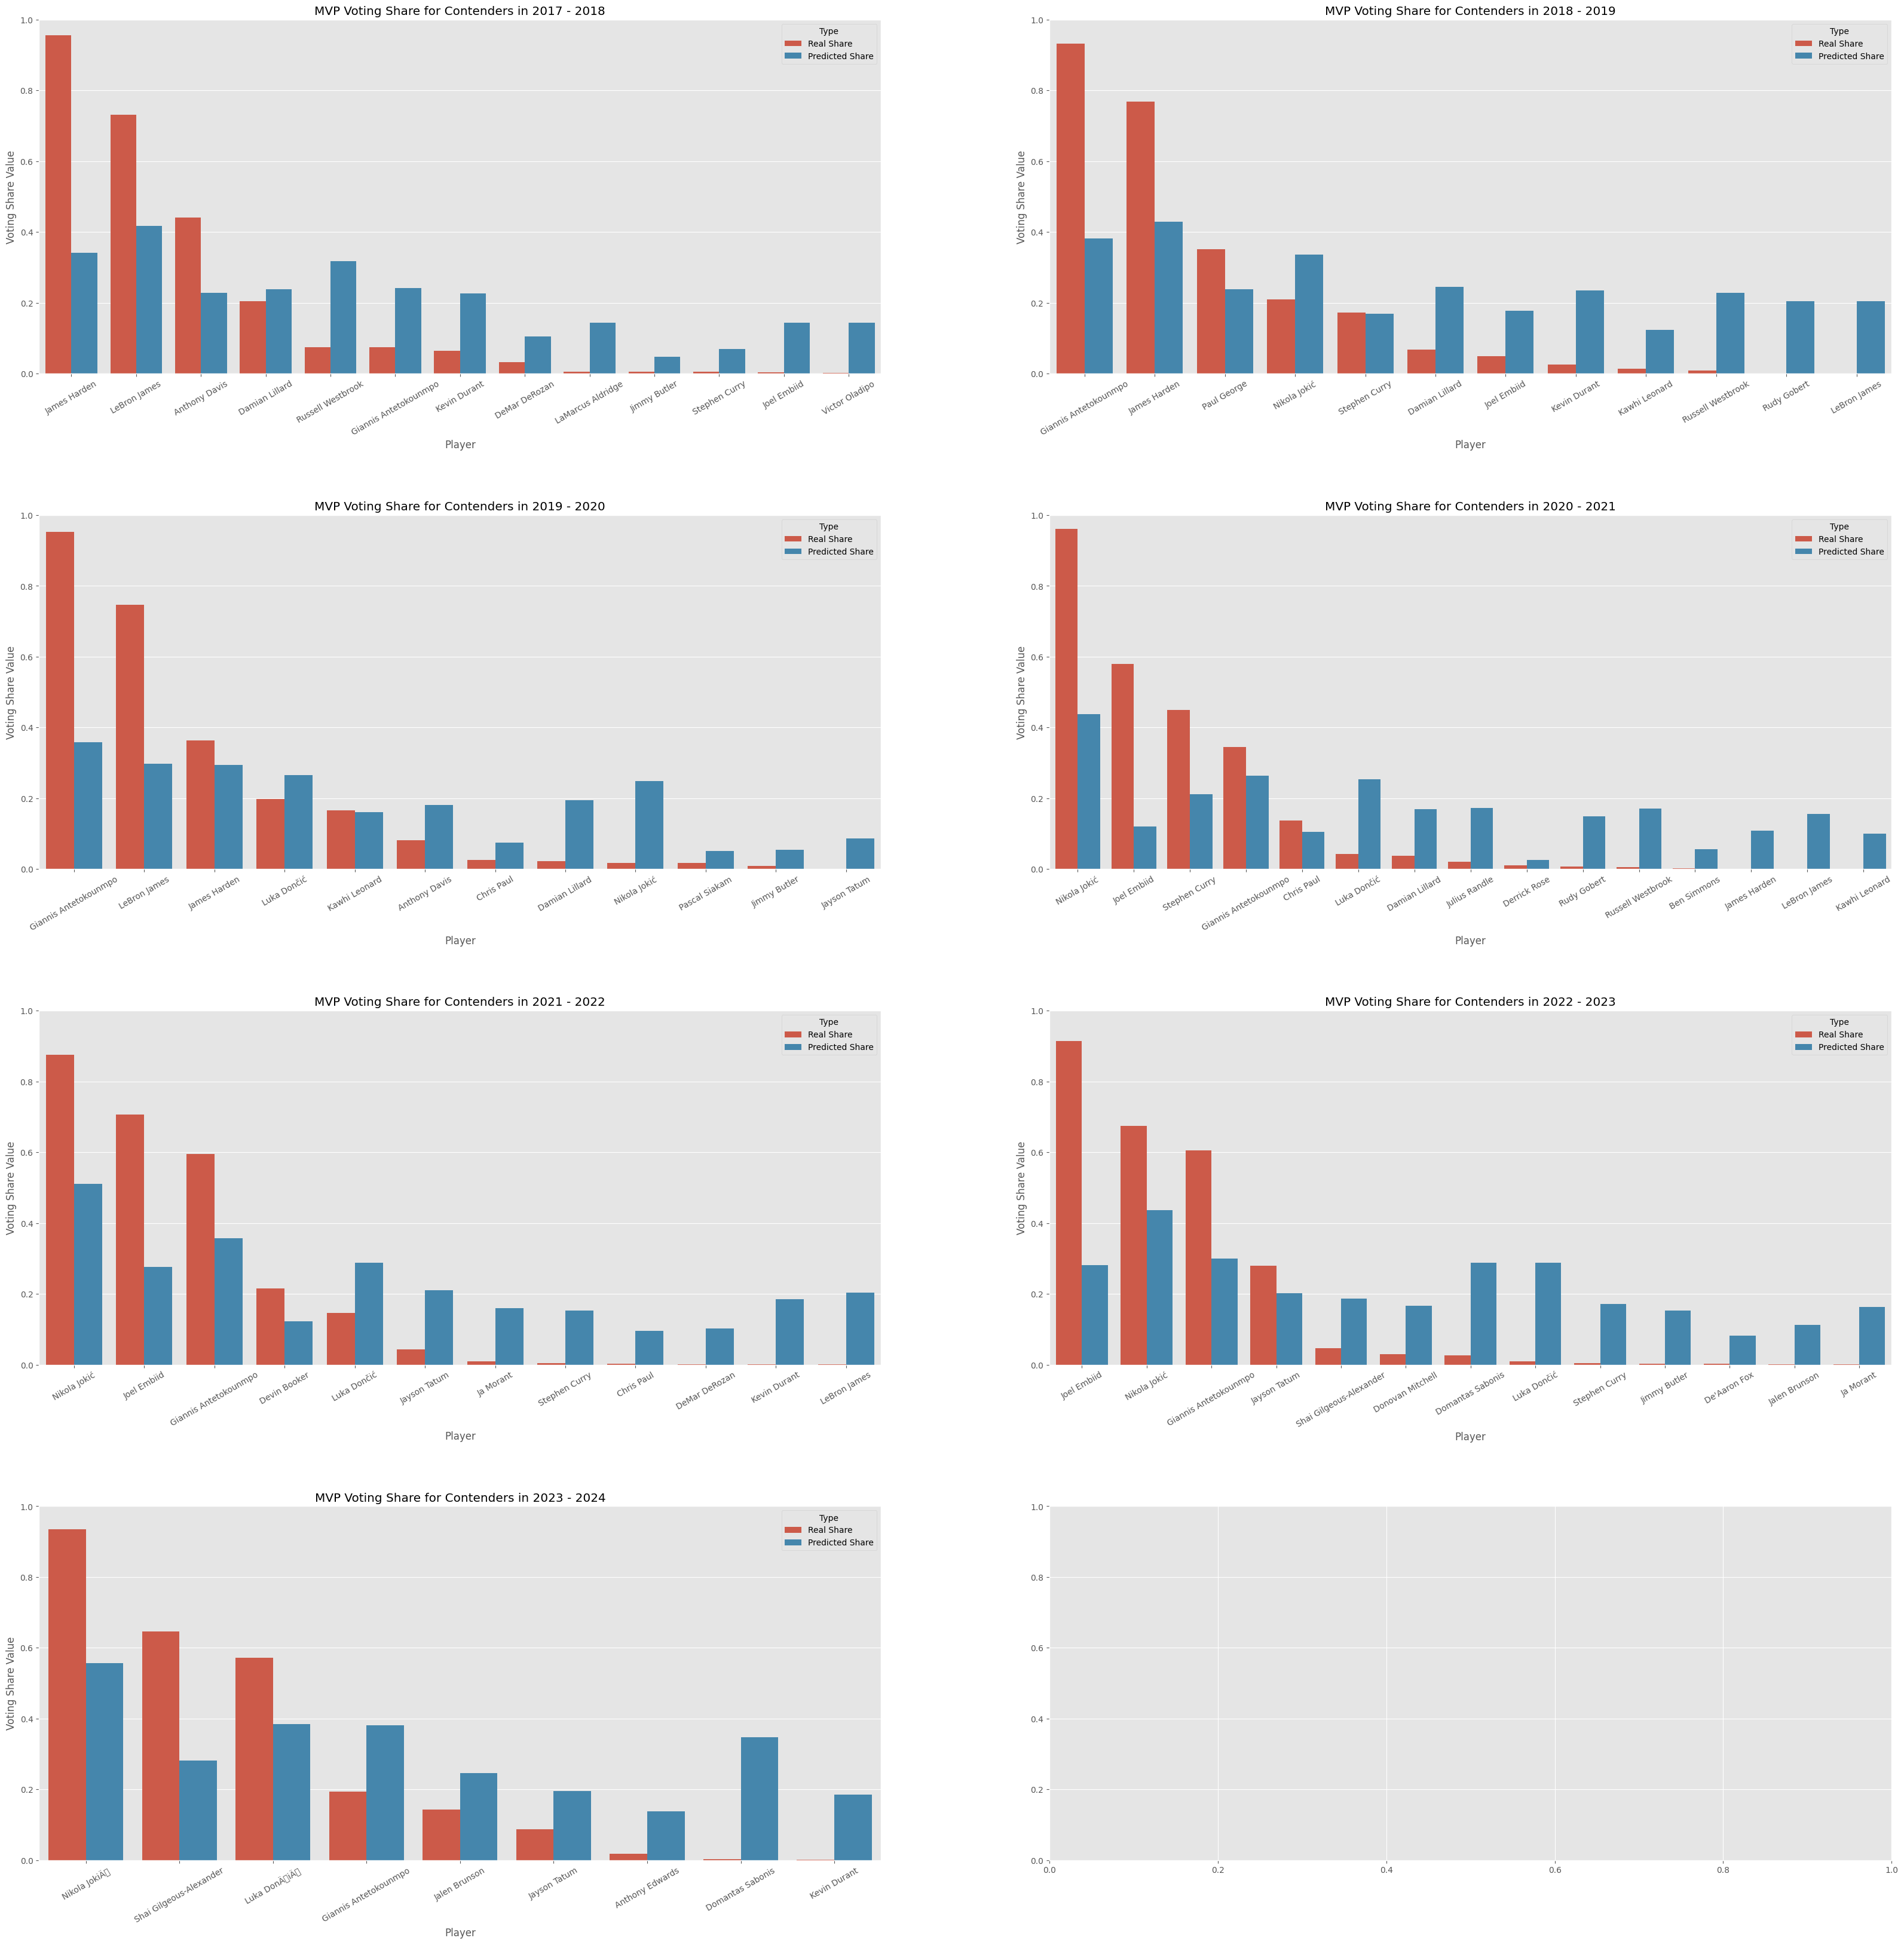

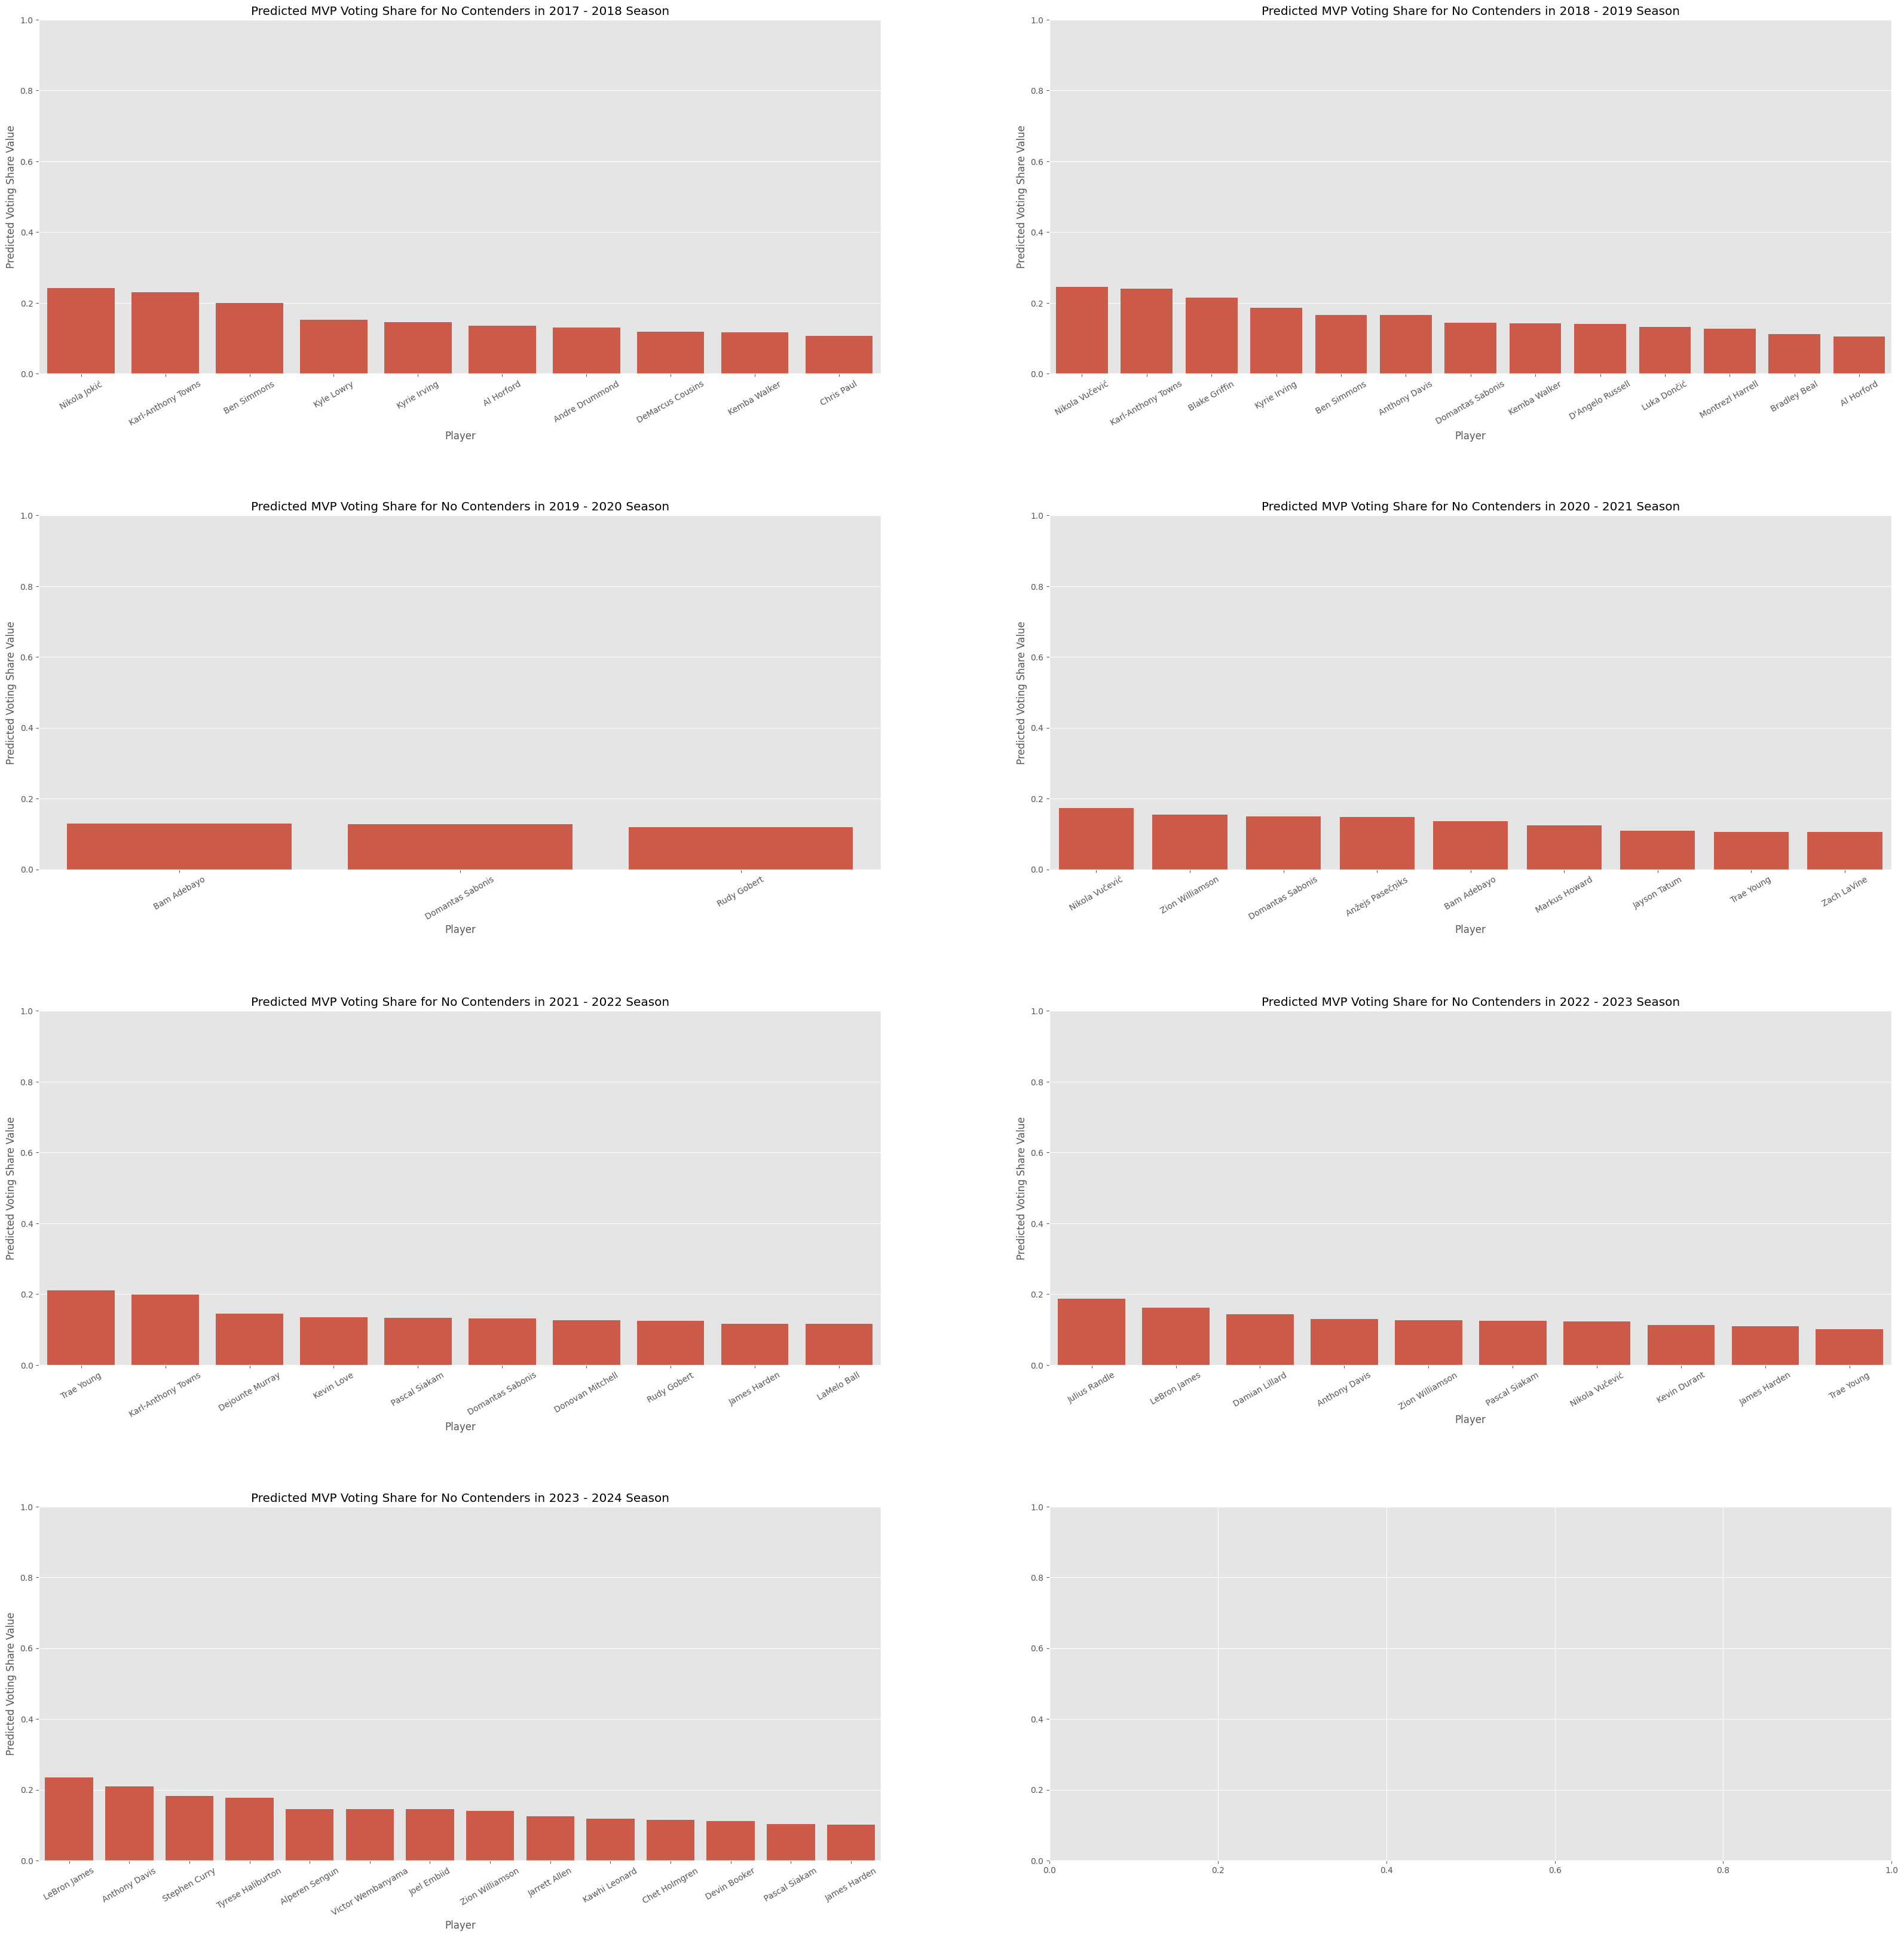

In [34]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

In [ ]:
# top_features = pd.DataFrame(best_model.feature_importances_, index = X_train.columns, columns = ['Importance']).sort_values('Importance', ascending = False)

In [ ]:
# top_features[top_features['Importance'] > 0.005]